In [0]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
# MNIST
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [3]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [0]:
# т.к. там int то преобразуем все во float
X_train = X_train.float()
X_test = X_test.float()

In [6]:
X_train.shape, X_test.shape
# картинки 28x28

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [7]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

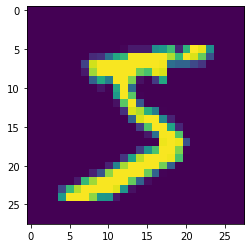

tensor(5)


In [8]:
import matplotlib.pyplot as plt
# Dsdtltv jlye rfhnbyre
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [0]:
# Из картинки 28x28 делаем вектор одномерный
# из трехмерного тензора делаем двуумерный (1 - все изображения, 2- вектор для изображения из его матрицы)
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [0]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

In [0]:
# ВКЛЮЧАЕМ GPU

In [12]:
# проверим видит ли торч наше gpu
torch.cuda.is_available()

True

In [13]:
# смотрим занята ли видеокарта вычислениями
!nvidia-smi

Tue Apr 14 21:55:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [14]:
# Включаем вычисление на gpu
# перекладываем тензоры на видеокарту: 1) веса сета 2) картинки для входом нн
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)  # перекладываем нн на gpu
list(mnist_net.parameters())  # выведем параметры нн (видим device='cuda:0' - т.е. они на видекарте)

[Parameter containing:
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [ 0.0221,  0.0258, -0.0088,  ..., -0.0141,  0.0051, -0.0318],
         [-0.0217, -0.0136,  0.0185,  ..., -0.0012, -0.0012, -0.0017],
         [ 0.0142,  0.0089, -0.0053,  ...,  0.0311, -0.0181,  0.0020]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([-3.5402e-02,  1.8178e-02, -2.1709e-02, -1.1839e-02,  4.8722e-03,
         -1.0492e-02, -1.9008e-02,  2.6994e-02, -3.4899e-02,  1.0381e-02,
         -3.5228e-02, -5.6381e-03, -2.0134e-02, -3.0264e-02, -1.3289e-02,
          2.5346e-02, -1.0797e-02,  2.1568e-03,  4.3630e-03, -2.1916e-02,
          2.2670e-02, -1.5766e-02,  3.4906e-02, -2.3063e-02, -6.8216e-03,
          2.7051e-02, -1.3991e-02,  9.7218e-03, -9.9075e-04,  1.6625e-03,
          2.3455e-02, -2

In [0]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [16]:
batch_size = 100

# для графиков
test_accuracy_history = []
test_loss_history = []

# для GPU перекладываем тензоры тестовые
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(20):
  order = np.random.permutation(len(X_train))

  for start_index in range(0, len(X_train), batch_size):
    optimizer.zero_grad()
    batch_indexes = order[start_index:start_index+batch_size]

    # для GPU перекладываем тензоры тренировочные по батчам (...to(device))
    X_batch = X_train[batch_indexes].to(device)
    y_batch = y_train[batch_indexes].to(device)

    preds = mnist_net.forward(X_batch)

    loss_value = loss(preds, y_batch)
    loss_value.backward()

    optimizer.step()
  
  # смотрим качество на тестовом датасете
  test_preds = mnist_net.forward(X_test)
  test_loss_history.append(loss(test_preds, y_test))  # сохраняем loss

  accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
  test_accuracy_history.append(accuracy) # сохраняем accuracy

  print(accuracy)

tensor(0.9105, device='cuda:0')
tensor(0.9071, device='cuda:0')
tensor(0.9141, device='cuda:0')
tensor(0.9213, device='cuda:0')
tensor(0.9238, device='cuda:0')
tensor(0.9245, device='cuda:0')
tensor(0.9251, device='cuda:0')
tensor(0.9269, device='cuda:0')
tensor(0.9245, device='cuda:0')
tensor(0.9323, device='cuda:0')
tensor(0.9309, device='cuda:0')
tensor(0.9335, device='cuda:0')
tensor(0.9389, device='cuda:0')
tensor(0.9344, device='cuda:0')
tensor(0.9358, device='cuda:0')
tensor(0.9389, device='cuda:0')
tensor(0.9377, device='cuda:0')
tensor(0.9316, device='cuda:0')
tensor(0.9358, device='cuda:0')
tensor(0.9424, device='cuda:0')


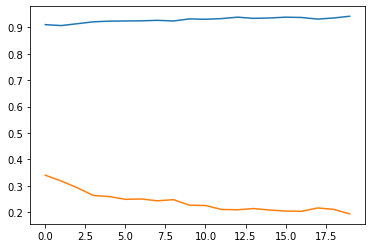

In [17]:
plt.plot(test_accuracy_history)
plt.plot(test_loss_history);
# Колебания в loss обычно меньше колебаний в accuracy
#  потому что accuracy - уже округленные значния
#  а в loss учитываются вероятности которые не так дискретны -> Не дают жестких колебаний на графике
